In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.9.1


In [3]:
results_file = 'write/critical.h5ad'  # the file that will store the analysis results


In [4]:
adata = sc.read_h5ad(
    'BCR_Critical.h5ad')  # the directory with the `.mtx` file


In [5]:
adata.var_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


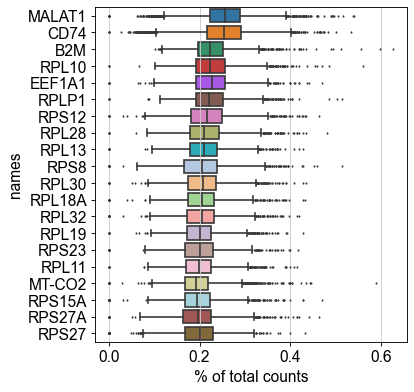

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16423 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

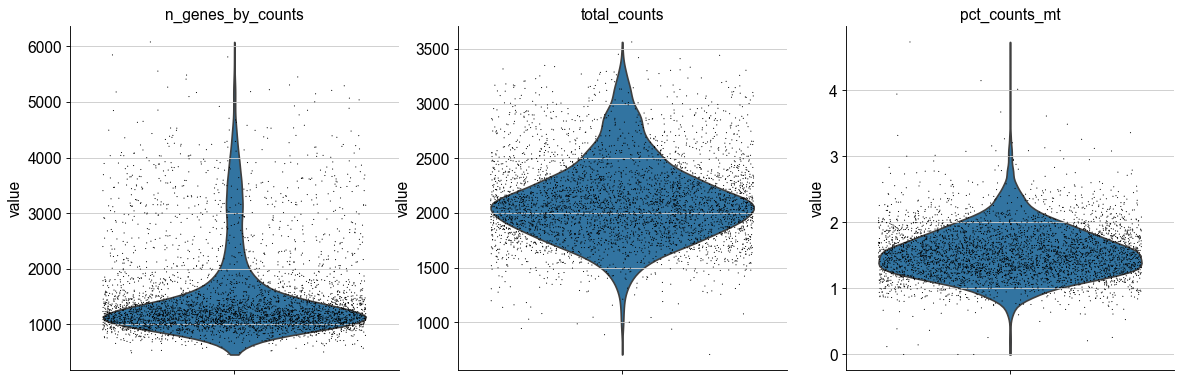

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

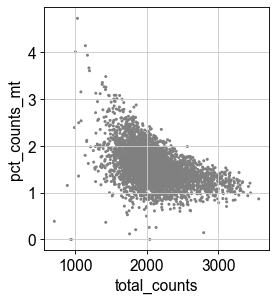

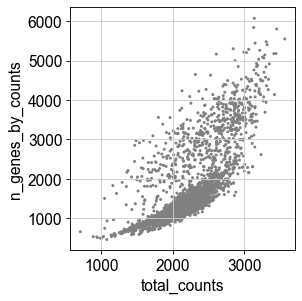

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [12]:
adata.X = scipy.sparse.csr_matrix(adata.X)

In [13]:
sc.pp.highly_variable_genes(adata)


extracting highly variable genes
/Users/sophieliu/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:00)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


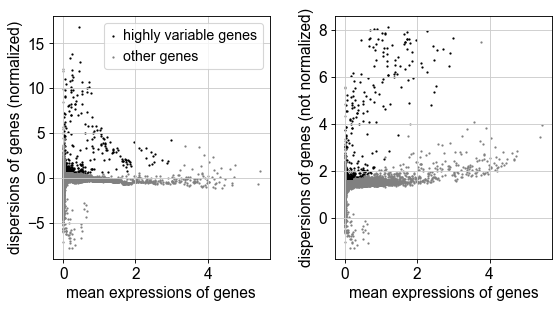

In [14]:
sc.pl.highly_variable_genes(adata)


In [15]:
adata.raw = adata


In [16]:
adata = adata[:, adata.var.highly_variable]


In [17]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


In [18]:
sc.pp.scale(adata, max_value=10)


In [19]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


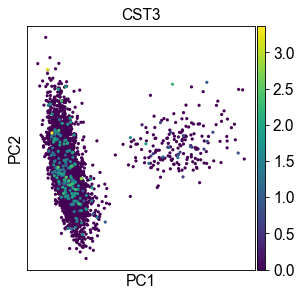

In [20]:
sc.pl.pca(adata, color='CST3')


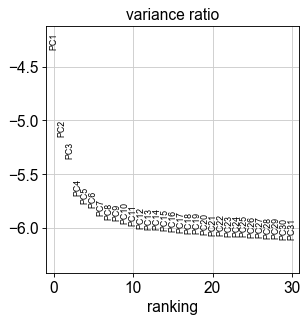

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)


In [22]:
adata.write(results_file)


In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [24]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [25]:
sc.tl.leiden(adata)
#i had to do pip install leiden alg 

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


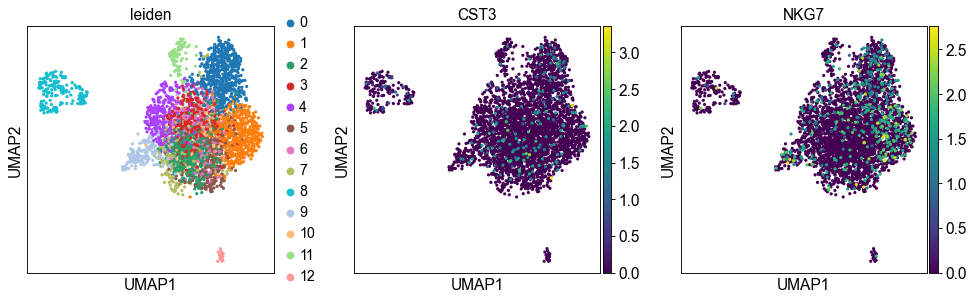

In [26]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
adata.write(results_file)


ranking genes
/Users/sophieliu/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


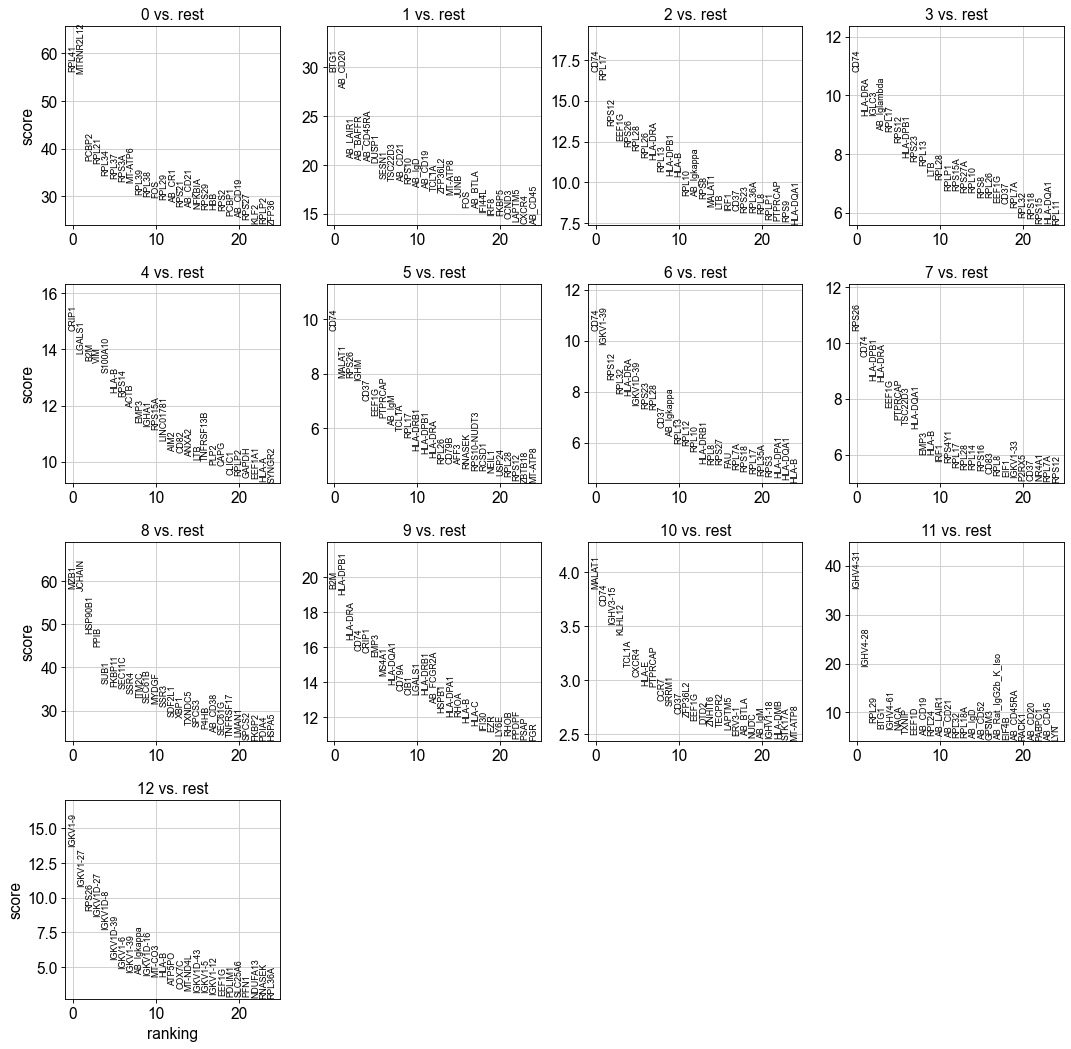

In [27]:

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [28]:
sc.settings.verbosity = 2  # reduce the verbosity


ranking genes
    finished (0:00:05)


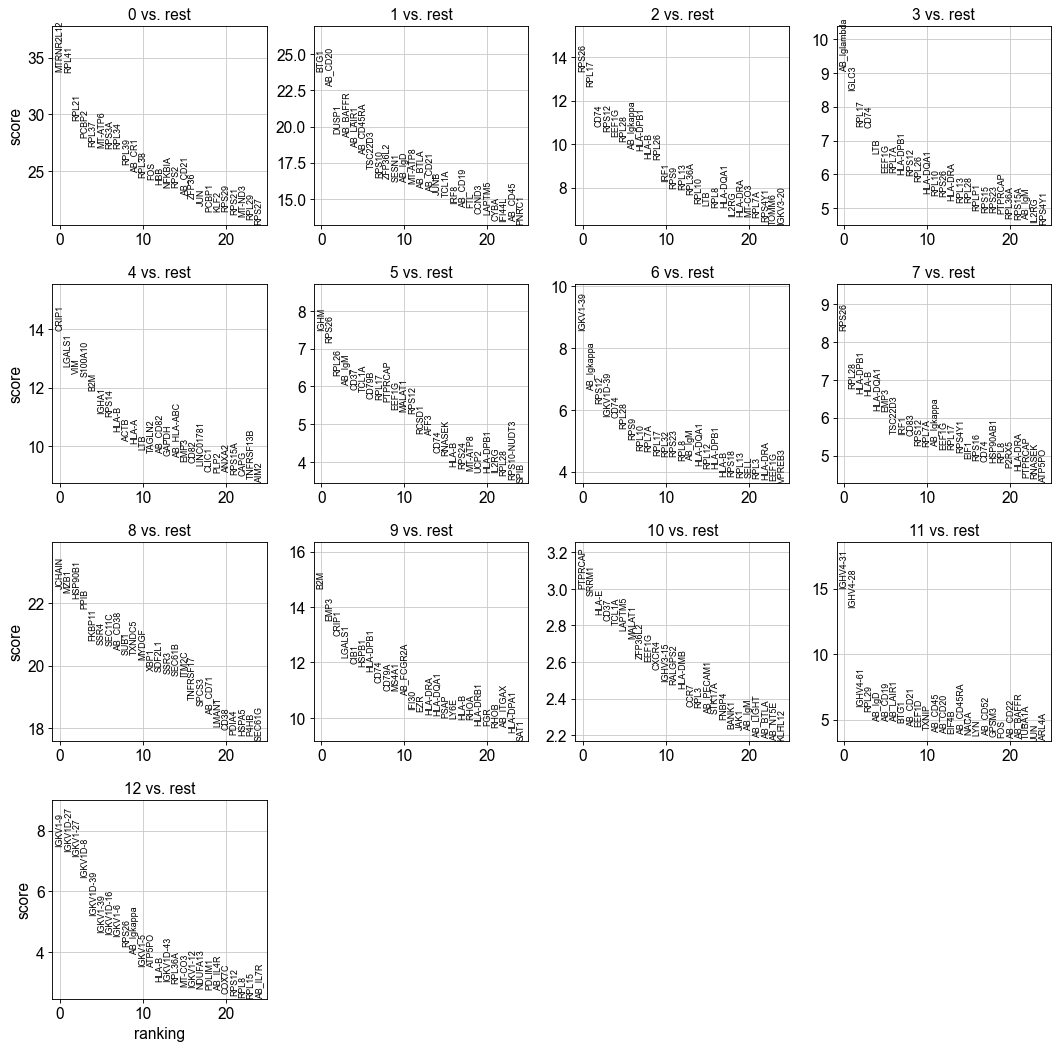

In [29]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [30]:
adata.write(results_file)

ranking genes
/Users/sophieliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
    finished (0:00:12)


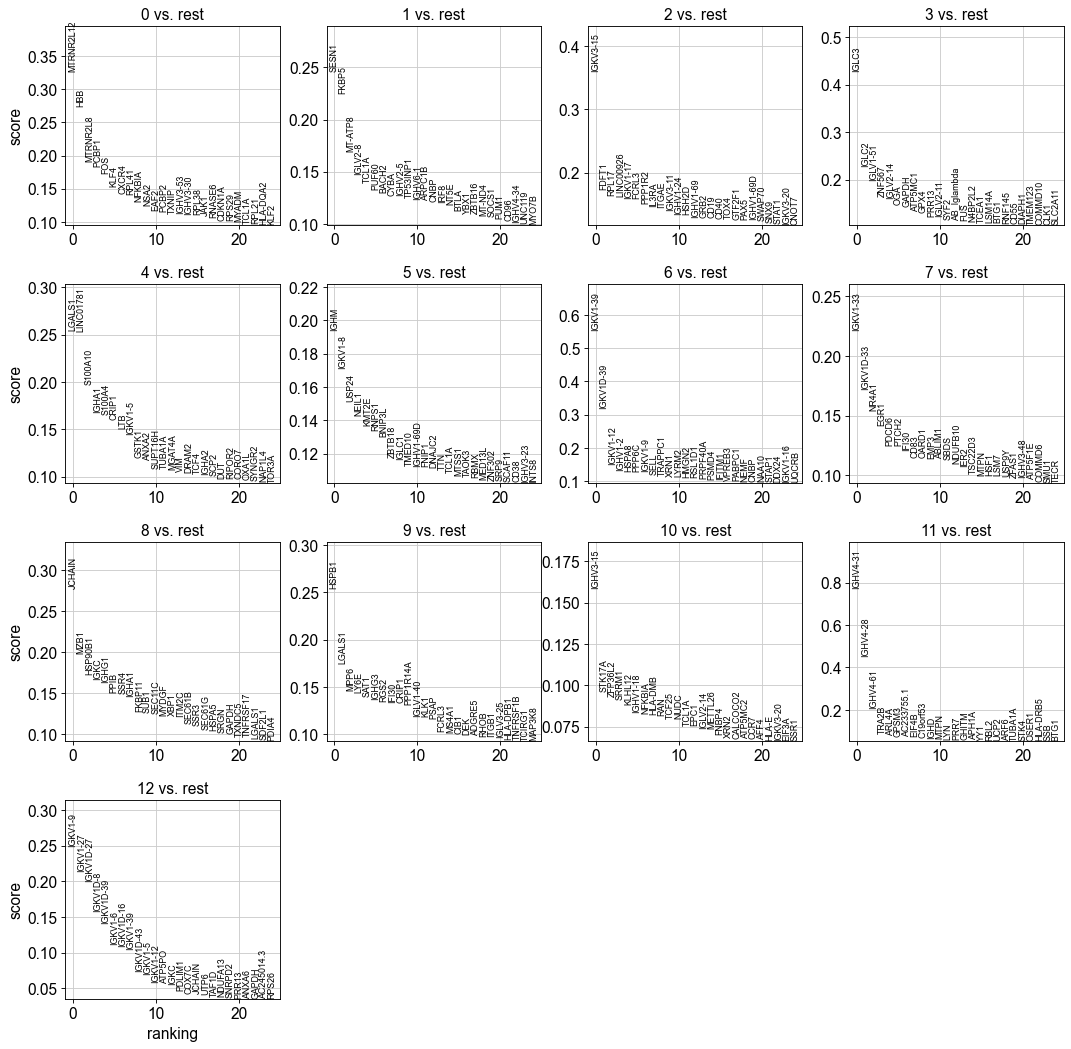

In [31]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
marker_genes = ['IGHA1', 'JCHAIN', 'IGHV3-43', 'IGKV2D-28', 'IGKV2-28', 'IGKV1-33', 'IGLC3']

In [33]:
adata = sc.read(results_file)


In [34]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,MTRNR2L12,BTG1,RPS26,AB_Iglambda,CRIP1,IGHM,IGKV1-39,RPS26,JCHAIN,B2M,PTPRCAP,IGHV4-31,IGKV1-9
1,RPL41,AB_CD20,RPL17,IGLC3,LGALS1,RPS26,AB_Igkappa,RPL28,MZB1,EMP3,SRRM1,IGHV4-28,IGKV1D-27
2,RPL21,DUSP1,CD74,RPL17,VIM,RPL26,RPS12,HLA-DPB1,HSP90B1,CRIP1,HLA-E,IGHV4-61,IGKV1-27
3,PCBP2,AB_BAFFR,RPS12,CD74,S100A10,AB_IgM,IGKV1D-39,HLA-B,PPIB,LGALS1,CD37,RPL29,IGKV1D-8
4,RPL37,AB_LAIR1,EEF1G,LTB,B2M,CD37,CD74,HLA-DQA1,FKBP11,CIB1,TCL1A,AB_IgD,IGKV1D-39


In [35]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p
0,MTRNR2L12,1.083141e-249,BTG1,5.646589e-125,RPS26,1.502587e-40,AB_Iglambda,1.672338e-19,CRIP1,1.923453e-44,...,JCHAIN,5.845173e-112,B2M,7.856048e-49,PTPRCAP,0.002657,IGHV4-31,3.936771e-51,IGKV1-9,6.651952e-14
1,RPL41,7.640692e-249,AB_CD20,1.181674e-114,RPL17,8.357839e-37,IGLC3,2.210834e-17,LGALS1,4.239784e-37,...,MZB1,1.612567e-110,EMP3,1.208779e-41,SRRM1,0.003004,IGHV4-28,5.282785e-42,IGKV1D-27,2.607908e-13
2,RPL21,7.975073e-191,DUSP1,4.548592e-85,CD74,3.090149e-27,RPL17,1.162788e-13,VIM,9.731184e-36,...,HSP90B1,8.657977e-109,CRIP1,1.969301e-38,HLA-E,0.004195,IGHV4-61,1.682577e-09,IGKV1-27,8.264088e-13
3,PCBP2,1.576304e-172,AB_BAFFR,9.389503e-83,RPS12,3.387623e-26,CD74,1.291857e-13,S100A10,3.032931e-35,...,PPIB,1.311476e-105,LGALS1,3.143124e-34,CD37,0.004687,RPL29,1.915181e-08,IGKV1D-8,9.917401e-11
4,RPL37,8.506991e-163,AB_LAIR1,3.381193e-77,EEF1G,3.184743e-25,LTB,3.412827e-11,B2M,1.023991e-32,...,FKBP11,2.624754e-96,CIB1,4.466753e-33,TCL1A,0.005011,AB_IgD,8.876063e-07,IGKV1D-39,1.969222e-07


ranking genes
/Users/sophieliu/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
    finished (0:00:01)


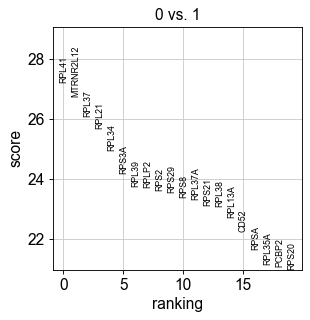

In [36]:

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

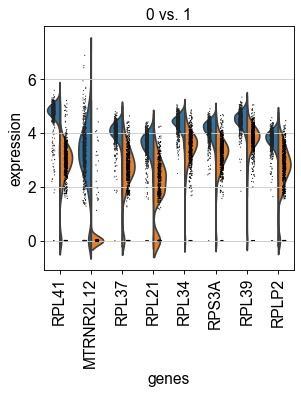

In [37]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
